In [1]:
%matplotlib inline
import keras
from keras.optimizers import RMSprop
from keras.utils import np_utils
from glob import glob
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import json

#from keras.applications.resnet50 import ResNet50
# not using keras version since it cannot have an input size < 197x197.  Might also require 3-channel color.
# found one online & modifying for my purposes
import resnet

/home/rallen/anaconda3/envs/romer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/rallen/anaconda3/envs/romer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train_path = 'data/train3'
train_input_image_names = glob(train_path+'/crop_score*png')
train_input_image_names.sort()
train_input_images = np.stack([np.array(Image.open(fn)) for fn in train_input_image_names])
train_input_images.shape = train_input_images.shape + (1,)
num_train_images,rows,cols,channels = train_input_images.shape
num_train_images,rows,cols,channels

(69464, 120, 32, 1)

In [3]:
valid_path = 'data/valid3'
valid_input_image_names = glob(valid_path+'/crop_score*png')
valid_input_image_names.sort()
valid_input_images = np.stack([np.array(Image.open(fn)) for fn in valid_input_image_names])
valid_input_images.shape = valid_input_images.shape + (1,)
num_valid_images,rows,cols,channels = valid_input_images.shape
num_valid_images,rows,cols,channels

(8682, 120, 32, 1)

In [4]:
results_json = 'data/train3/crop_score_info.json'
with open(results_json,'r') as f:
    results = json.load(f)
# array of values.  each one is: pitch, length, key

In [5]:
train_indices = []
for train_name in train_input_image_names:
    index = int(train_name.split('.')[0].split('_')[-1])
    train_indices.append(index)
valid_indices = []
for valid_name in valid_input_image_names:
    index = int(valid_name.split('.')[0].split('_')[-1])
    valid_indices.append(index)
#train_indices[:20],valid_indices[:20]

In [6]:
# there is 1 'no pitch' value, 1 rest value (-1) and 128 midi notes (0-127)
pitches = np.zeros(128+1+1,dtype=np.int32)
lengths = np.zeros(16+1,dtype=np.int32)
keys = np.zeros(15,dtype=np.int32) # values from 0..14
for ti in train_indices:
    r = results[ti]
    pitches[r[0]] += 1
    lengths[r[1]] += 1
    keys[r[2]]    += 1

In [7]:
keys

array([ 2277,  2336,  2372,  2356,  2332,  2307,  2843, 35836,  2303,
        2332,  2354,  2281,  2304,  2309,  2922], dtype=int32)

In [8]:
# train pitch,length results, key inputs
NUM_PITCH_CATEGORIES=128+1+1 
NUM_LENGTH_CATEGORIES=16+1
NUM_KEY_BITS=4 # 0-14
train_pitch_results = np.zeros(len(train_indices),dtype=np.float32)
train_length_results = np.zeros(len(train_indices),dtype=np.float32)
train_key_inputs = np.zeros((len(train_indices),NUM_KEY_BITS),dtype=np.float32)
i = 0
for ti in train_indices:
    r = results[ti]
    train_pitch_results[i]  = r[0] 
    train_length_results[i] = r[1]
    train_key_inputs[i]     = np.array(list(np.binary_repr(r[2],width=NUM_KEY_BITS)),dtype=np.float32)
    i += 1
train_pitch_results = np_utils.to_categorical(train_pitch_results,NUM_PITCH_CATEGORIES)
train_length_results = np_utils.to_categorical(train_length_results,NUM_LENGTH_CATEGORIES)

In [9]:
train_pitch_results.shape, train_length_results.shape, train_key_inputs.shape

((69464, 130), (69464, 17), (69464, 4))

In [10]:
train_pitch_results[100], train_length_results[100], train_key_inputs[100]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 1.], dtype=float32))

In [11]:
valid_pitch_results = np.zeros(len(valid_indices),dtype=np.float32)
valid_length_results = np.zeros(len(valid_indices),dtype=np.float32)
valid_key_inputs = np.zeros((len(valid_indices),NUM_KEY_BITS),dtype=np.float32)
i = 0
for ti in valid_indices:
    r = results[ti]
    valid_pitch_results[i]  = r[0] 
    valid_length_results[i] = r[1]
    valid_key_inputs[i]     = np.array(list(np.binary_repr(r[2],width=NUM_KEY_BITS)),dtype=np.float32)
    i += 1
valid_pitch_results = np_utils.to_categorical(valid_pitch_results,NUM_PITCH_CATEGORIES)
valid_length_results = np_utils.to_categorical(valid_length_results,NUM_LENGTH_CATEGORIES)

In [12]:
# you need a generator that yields something of the form ([x1, x2], y)
class dual_generator(object):
    """X1 should be list of score images, X2 should be a list of keys, 
    Y1 should be a list of pitch results, Y2 should be a list of length results.  
    All should be the same length."""
    def __init__(self, X1, X2, Y1, Y2, batch_size, channels):
        self.X1 = X1
        self.X2 = X2
        self.Y1 = Y1
        self.Y2 = Y2
        self.bs = batch_size
        self.channels = channels
        self.i  = 0
    def __next__(self):
        xs1 = self.X1[self.i:self.i+self.bs]
        xs2 = self.X2[self.i:self.i+self.bs]
        ys1 = self.Y1[self.i:self.i+self.bs]
        ys2 = self.Y2[self.i:self.i+self.bs]
        self.i = (self.i + self.bs) % self.X1.shape[0]
        return [xs1, xs2], [ys1, ys2]

In [13]:
batch_size = 32
train_generator = dual_generator(train_input_images, train_key_inputs, 
                                 train_pitch_results, train_length_results, 
                                 batch_size, channels)
valid_generator = dual_generator(valid_input_images, valid_key_inputs, 
                                 valid_pitch_results, valid_length_results, 
                                 batch_size, channels)


In [14]:
image_shape = (rows,cols,channels)
model = resnet.RomerResnetBuilder.build_romer_resnet_18(image_shape, NUM_KEY_BITS, 
                                                        NUM_PITCH_CATEGORIES, NUM_LENGTH_CATEGORIES)

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 32, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 16, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 60, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

Find the learning rate
----

In [16]:
from train_utils import ExponentialLR, CyclicalCosineWithRestartsLR

In [ ]:
lr = ExponentialLR(num_train_images//batch_size,1e-9,1.0)

In [ ]:
model = resnet.RomerResnetBuilder.build_romer_resnet_18(image_shape, NUM_KEY_BITS, 
                                                        NUM_PITCH_CATEGORIES, NUM_LENGTH_CATEGORIES)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-9),
              metrics=["accuracy"])
model.fit_generator(train_generator,
                    num_train_images//batch_size, 1,
                    callbacks=[lr],
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

In [ ]:
for i in range(len(lr.history['lr'])):
    if 1e-4 <= lr.history['lr'][i] < 1e-4+1e-6:
        print(i)
        break

In [ ]:
A,B=1000,1500
#plt.semilogx(lr.history['lr'][1000:1500], lr.history['loss'][1000:1500])
plt.semilogx(lr.history['lr'], lr.history['loss'])
plt.ylim([0,20])
plt.axvline(x=1e-4,color='k')
plt.axhline(y=lr.history['loss'][1207],color='k')

In [ ]:
A,B=900,1300
plt.semilogx(lr.history['lr'][A:B], lr.history['loss'][A:B])
plt.axvline(x=0.00005)
plt.axvline(x=0.00009)
plt.axvline(x=1e-4)

Train the model
-----

In [17]:
train_rate = 1e-4
num_epochs = 6
lr = CyclicalCosineWithRestartsLR((num_train_images//batch_size)*3, 0.0, train_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(train_rate),
              metrics=["accuracy"])
model.fit_generator(train_generator,
                    num_train_images//batch_size, num_epochs,
                    callbacks=[lr],
                    #verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

Epoch 1/6
2170/2170 [==============================] - 88s 41ms/step - loss: 1.4111 - dense_1_loss: 0.5551 - dense_2_loss: 0.3097 - dense_1_acc: 0.8727 - dense_2_acc: 0.9138 - val_loss: 1.1312 - val_dense_1_loss: 0.3084 - val_dense_2_loss: 0.3005 - val_dense_1_acc: 0.9222 - val_dense_2_acc: 0.9116
Epoch 2/6
2170/2170 [==============================] - 88s 41ms/step - loss: 0.7757 - dense_1_loss: 0.1243 - dense_2_loss: 0.1477 - dense_1_acc: 0.9758 - dense_2_acc: 0.9558 - val_loss: 0.9120 - val_dense_1_loss: 0.2386 - val_dense_2_loss: 0.1808 - val_dense_1_acc: 0.9623 - val_dense_2_acc: 0.9506
Epoch 3/6
2170/2170 [==============================] - 88s 41ms/step - loss: 0.6901 - dense_1_loss: 0.0753 - dense_2_loss: 0.1273 - dense_1_acc: 0.9862 - dense_2_acc: 0.9684 - val_loss: 0.8058 - val_dense_1_loss: 0.1512 - val_dense_2_loss: 0.1687 - val_dense_1_acc: 0.9656 - val_dense_2_acc: 0.9539
Epoch 4/6
2170/2170 [==============================] - 88s 41ms/step - loss: 0.6653 - dense_1_loss: 0.0

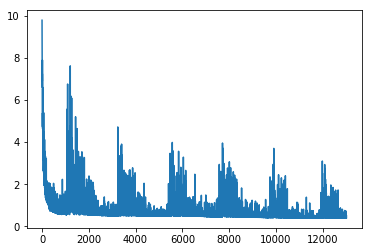

In [20]:
#plt.semilogx(lr.history['lr'], lr.history['loss'])
plt.plot(lr.history['loss'])

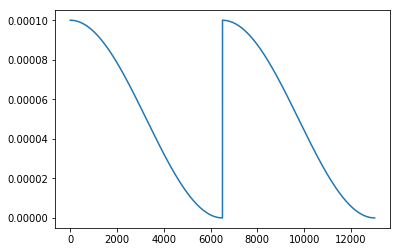

In [21]:
plt.plot(lr.history['lr'])

In [22]:
# Let's compare without the CosineLR
model = resnet.RomerResnetBuilder.build_romer_resnet_18(image_shape, NUM_KEY_BITS, 
                                                        NUM_PITCH_CATEGORIES, NUM_LENGTH_CATEGORIES)
train_rate = 1e-4
num_epochs = 6
#lr = CyclicalCosineWithRestartsLR((num_train_images//batch_size)*3, 0.0, train_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(train_rate),
              metrics=["accuracy"])
model.fit_generator(train_generator,
                    num_train_images//batch_size, num_epochs,
                    #callbacks=[lr],
                    #verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

Epoch 1/6
2170/2170 [==============================] - 88s 41ms/step - loss: 1.4098 - dense_3_loss: 0.5524 - dense_4_loss: 0.3128 - dense_3_acc: 0.8749 - dense_4_acc: 0.9173 - val_loss: 1.2923 - val_dense_3_loss: 0.3993 - val_dense_4_loss: 0.3756 - val_dense_3_acc: 0.9144 - val_dense_4_acc: 0.8818
Epoch 2/6
2170/2170 [==============================] - 87s 40ms/step - loss: 0.7463 - dense_3_loss: 0.1185 - dense_4_loss: 0.1417 - dense_3_acc: 0.9744 - dense_4_acc: 0.9562 - val_loss: 0.9401 - val_dense_3_loss: 0.2938 - val_dense_4_loss: 0.1844 - val_dense_3_acc: 0.9540 - val_dense_4_acc: 0.9577
Epoch 3/6
2170/2170 [==============================] - 87s 40ms/step - loss: 0.5805 - dense_3_loss: 0.0649 - dense_4_loss: 0.0850 - dense_3_acc: 0.9866 - dense_4_acc: 0.9736 - val_loss: 0.8544 - val_dense_3_loss: 0.2884 - val_dense_4_loss: 0.1587 - val_dense_3_acc: 0.9611 - val_dense_4_acc: 0.9626
Epoch 4/6
2170/2170 [==============================] - 88s 41ms/step - loss: 0.4877 - dense_3_loss: 0.0

In [23]:
# okay, Cosine was not "amazingly" better, but it is better.

In [ ]:
# not updated below...was going to edit python training model first.

In [ ]:
test_path = 'data/test3'
test_input_image_names = glob(test_path+'/crop_score*png')
test_input_image_names.sort()
test_input_images = np.stack([np.array(Image.open(fn)) for fn in test_input_image_names])
test_input_images.shape = test_input_images.shape + (1,)
num_test_images,rows,cols,channels = test_input_images.shape
num_test_images,rows,cols,channels

In [ ]:
test_indices = []
for test_name in test_input_image_names:
    index = int(test_name.split('.')[0].split('_')[-1])
    test_indices.append(index)

In [ ]:
test_results = np.zeros(len(test_indices),dtype=np.float32)
test_results1 = np.zeros(len(test_indices),dtype=np.float32)
i = 0
for ti in test_indices:
    r = results[ti]
    test_results[i] = r[0]
    test_results1[i] = r[1]
    i += 1
test_results = np_utils.to_categorical(test_results,NUM_CATEGORIES)
test_results1 = np_utils.to_categorical(test_results1,NUM_CATEGORIES1)

In [ ]:
test_generator = score_generator(test_input_images, test_results, batch_size, channels)
test_generator1 = score_generator(test_input_images, test_results1, batch_size, channels)

In [ ]:
model.evaluate_generator(test_generator,steps=num_test_images//batch_size)

In [ ]:
model1.evaluate_generator(test_generator1,steps=num_test_images//batch_size)